### Compare Extractors

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import torch
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from kcm.koopman_category_model import KoopmanCategoryModel
from kcm.basic_feature_extract import BasicFeatureExtractor
from kcm.discovery import (
    CategoryDiscoveryTrainer,
    train_test_split_indices,
    prep_data_for_discovery,
    check_histograms,
    sup_con_loss,
    BaselineModel,
    HASHHead,
    cluster_acc,
    split_cluster_acc_v1,
    split_cluster_acc_v2,
    create_hash_ids
)
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

import warnings
warnings.filterwarnings('ignore')


plt.style.use('dark_background')

In [2]:
# Reproducibility Code
seed=42
rng = np.random.default_rng(seed)

In [30]:
############### Shared Inputs ###############
num_cats = 4
num_samples = 100
system_dimension = 2
test_size = 0.2
category_discovery=True
train_classes = range(3)
noisy_data=False
noise_std=0.01
#############################################


############ kcm-specific inputs ############
delay_embeddings = 10
num_segments = 5
svd_rank = None
dmd_rank = None
q = 2
num_clusters = 15
codebook_training_size = 300 # divides <num training classes> * num_segments 
normalize_kcm_inputs=True
#############################################


###### basic extractor-specific inputs ######
drop_na=True
normalize_basic_inputs=False
#############################################

train_counts, test_counts = train_test_split_indices(num_cats,num_samples,test_size,train_classes,category_discovery,rng)

Category Discovery Split...
    Training Size: 240
    Testing Size: 160


### Prepare Data

In [ ]:
KCM = KoopmanCategoryModel(num_cats=num_cats,
                           num_samples=num_samples,
                           system_dimension=system_dimension,
                           delay_embeddings=delay_embeddings,
                           num_segments=num_segments,
                           svd_rank=svd_rank,
                           dmd_rank=dmd_rank,
                           q=q,
                           cluster_method='kmeans',
                           num_clusters=num_clusters,
                           noisy_data=noisy_data,
                           noise_std=noise_std,
                           normalize_inputs=normalize_kcm_inputs,
                           seed=seed)

KCM.generate_data()

kcm = KCM.df
kcm_train_data = kcm.loc[kcm['count'].isin(train_counts)].reset_index(drop=True)
kcm_test_data = kcm.loc[kcm['count'].isin(test_counts)].reset_index(drop=True)

KCM.df_train = kcm_train_data
KCM.df_test = kcm_test_data

assert int(kcm_train_data.shape[0]/num_segments) == len(train_counts), 'training samples not correct shape'
assert int(kcm_test_data.shape[0]/num_segments) == len(test_counts), 'testing samples not correct shape'

KCM.create_codebook(codebook_training_size=codebook_training_size,
                    category_discovery=category_discovery,
                    train_classes=train_classes,
                    include_plots=False)
KCM.save()
KCM.shutdown_logger()

kcm_train = np.hstack((KCM.inv_c_train_matrix, KCM.train_target.values[:,np.newaxis]))
kcm_test = np.hstack((KCM.inv_c_test_matrix, KCM.test_target.values[:,np.newaxis]))

# train test split
kcm_X_train, kcm_X_test, kcm_y_train, kcm_y_test, kcm_stacked = prep_data_for_discovery(train=kcm_train,
                                                                                        test=kcm_test,
                                                                                        normalize_final_data=False, # already normalized within kcm.create_codebook()
                                                                                        pca_reduction=False,
                                                                                        n_components=None,
                                                                                        feat_extractor='kcm')

Loading data in at C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\data\2-dimensional-systems\dataset_4_class_100_samples.pkl...
Creating df_sample for codebook


(1/2) * 300^2 = 45000 Wasserstein distance metrics:  49%|███████████████████                    | 147/300 [00:58<02:02,  1.25it/s]

In [6]:
Extractor = BasicFeatureExtractor(num_cats=num_cats,
                                  num_samples=num_samples,
                                  system_dimension=system_dimension,
                                  noisy_data=noisy_data,
                                  noise_std=noise_std,
                                  seed=seed)

Extractor.batch_extract_features(normalize_inputs=normalize_basic_inputs, drop_na=drop_na)

basic = Extractor.df
basic_train = basic.loc[basic['count'].isin(train_counts)]
basic_test = basic.loc[basic['count'].isin(test_counts)]

# train test split
basic_X_train, basic_X_test, basic_y_train, basic_y_test, basic_stacked = prep_data_for_discovery(train=basic_train,
                                                                                                  test=basic_test,
                                                                                                  normalize_final_data=True,
                                                                                                  pca_reduction=True,
                                                                                                  n_components=num_clusters, # make kcm and basic extract have same feature dimension
                                                                                                  feat_extractor='basic')

Loading data in at C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\data\2-dimensional-systems\dataset_4_class_100_samples.pkl...


Calculating features for all systems: 100%|█████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.31it/s]

Dropped columns: []
Final shape: (400, 39)


In [ ]:
check_histograms(basic_stacked), print('')
check_histograms(kcm_stacked)

In [17]:
# Comparing system-target mappings for basic extractor and kcm
mapping = basic[['system_name','target']].drop_duplicates().values
basic_system_dict = {row[1] : row[0] for row in mapping}
kcm_system_dict = {tgt : cat for cat,tgt in zip(KCM.cats,KCM.df['target'].drop_duplicates())}
assert basic_system_dict == kcm_system_dict, 'Dictionaries do not match between extractors'

assert (basic.target.values == KCM.df[['target','sample']].drop_duplicates()['target'].values).all()
assert (basic_train.target.values == KCM.df_train[['target','sample']].drop_duplicates()['target'].values).all()
assert (basic_test.target.values == KCM.df_test[['target','sample']].drop_duplicates()['target'].values).all()

In [19]:
############## Training Parameters ##############
input_dim = num_clusters
output_dim = 6
hidden_dims = [200,200] # [200, 200], [1024, 512, 256]
dropout = 0.3
classes = num_cats
epochs = 500
model_type = 'SMILE' # baseline, SMILE
temperature = 0.2
#################################################

kcm_trainer = CategoryDiscoveryTrainer(input_dim=input_dim,
                                       output_dim=output_dim,
                                       hidden_dims=hidden_dims,
                                       dropout=dropout,
                                       classes=classes,
                                       epochs=epochs,
                                       model_type=model_type,
                                       temperature=temperature)

basic_trainer = CategoryDiscoveryTrainer(input_dim=input_dim,
                                         output_dim=output_dim,
                                         hidden_dims=hidden_dims,
                                         dropout=dropout,
                                         classes=classes,
                                         epochs=epochs,
                                         model_type=model_type,
                                         temperature=temperature)

In [ ]:
kcm_trainer.train_model(kcm_X_train, kcm_X_test, kcm_y_train, kcm_y_test)

In [20]:
basic_trainer.train_model(basic_X_train, basic_X_test, basic_y_train, basic_y_test)

Training SMILE Model: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.05it/s]


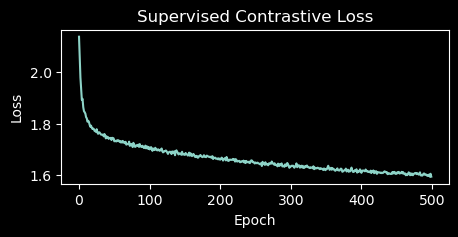

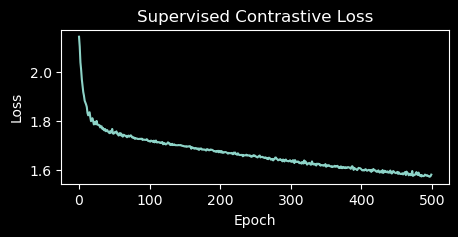

In [26]:
kcm_trainer.plot_loss(log=True)
basic_trainer.plot_loss(log=True)

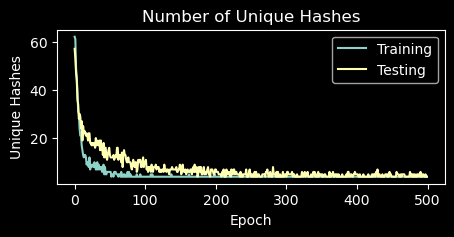

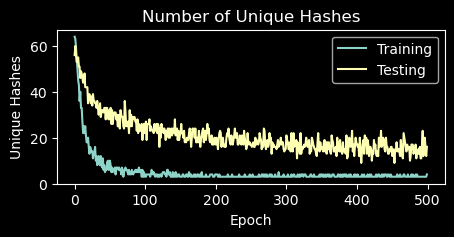

In [27]:
kcm_trainer.plot_unique_hash_count()
basic_trainer.plot_unique_hash_count()

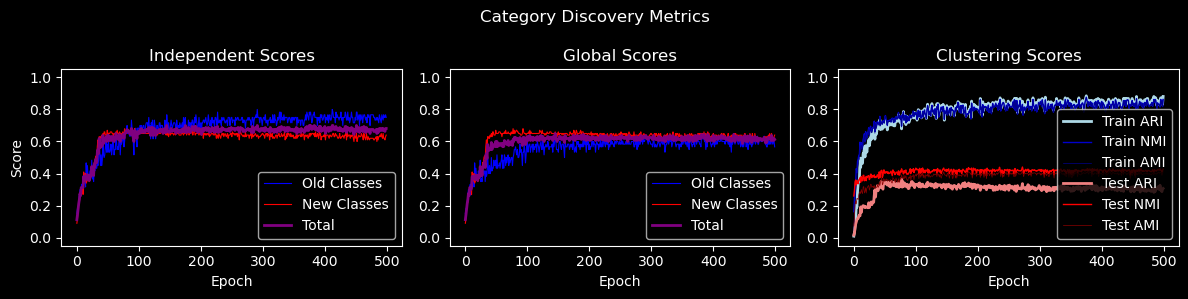

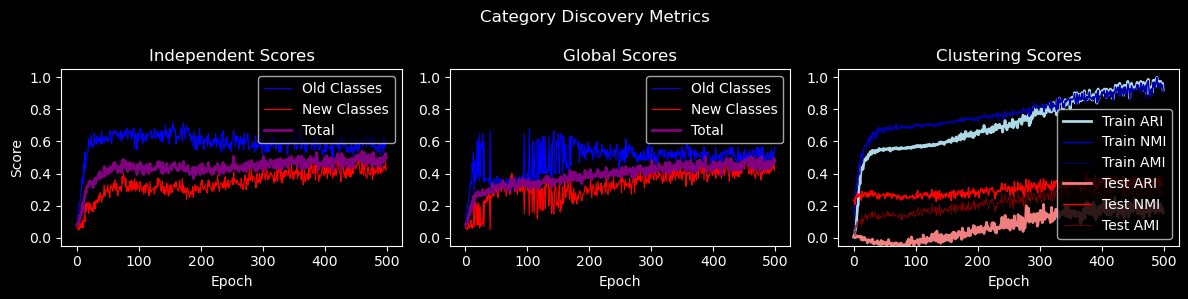

In [28]:
kcm_trainer.plot_scores()
basic_trainer.plot_scores()

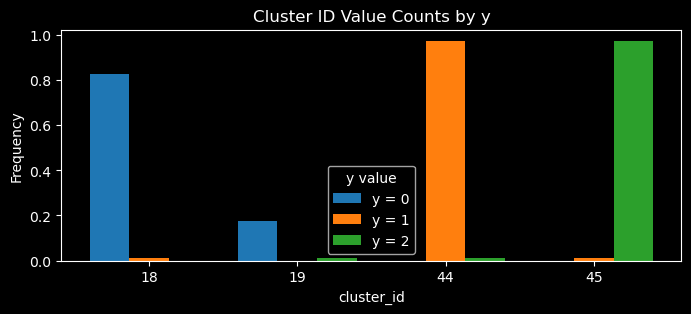

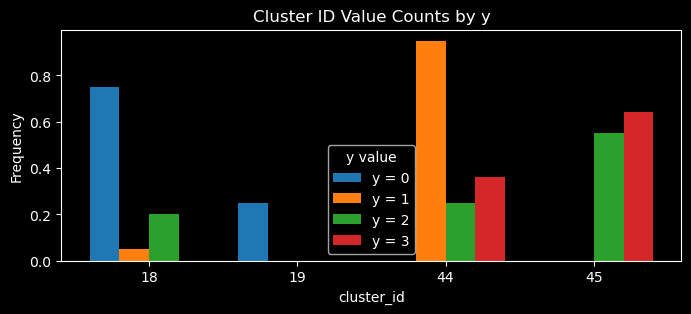

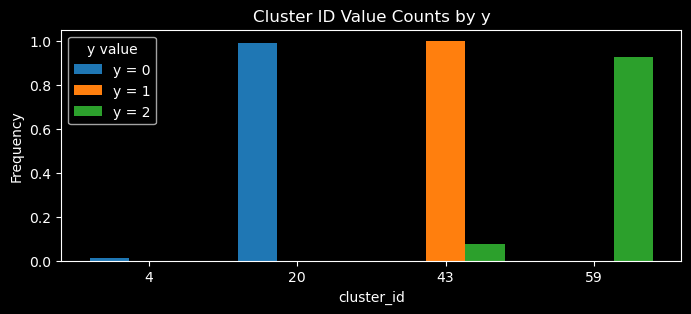

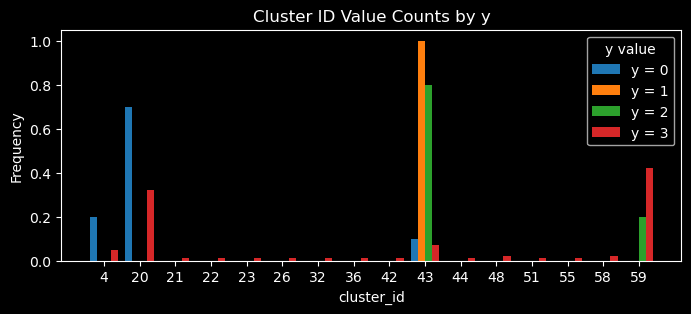

In [29]:
kcm_trainer.plot_hashes(index=-1,split_testing=False)
basic_trainer.plot_hashes(index=-1,split_testing=False)

### Classification Testing

In [45]:
# Prepare data for classification
df = Extractor.df
X = df.drop(columns=['system_name','target','count']).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Normalize based on training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train classification model
model = LogisticRegression()
model.fit(X_train_pca,y_train)
cm = confusion_matrix(model.predict(X_test_pca), y_test)

print(f'Score: {model.score(X_test_pca, y_test)}')
print(cm)

Score: 0.9005714285714286
[[149   0   7   0   0   0   0]
 [  0 128   0   0   0   0   0]
 [  0   0  71   0   0  37   0]
 [  0   0   0 128   0   0   1]
 [  0   0   0   0 112   0   0]
 [  0   0  42   0   0  76   0]
 [  0   0   0   0   0   0 124]]


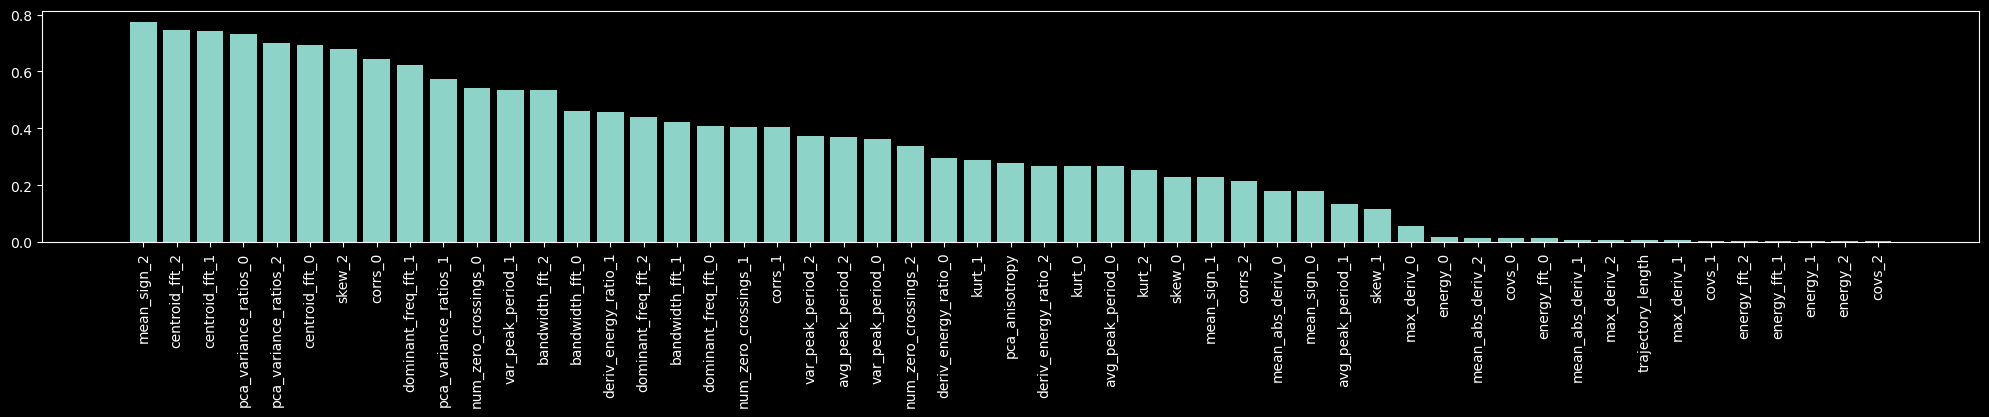

In [50]:
# Train classification model on all features for feature importance visualization
model = LogisticRegression()
model.fit(X_train,y_train)
cm = confusion_matrix(model.predict(X_test), y_test)

feature_cols = df.columns[:-3]
importance_mean = abs(model.coef_).mean(axis=0)
importance_order = np.argsort(importance_mean)

plt.figure(figsize=(25,3))
plt.bar(np.arange(len(feature_cols)), importance_mean[importance_order[::-1]], align='center')
plt.xticks(ticks=np.arange(len(feature_cols)), labels=feature_cols[importance_order[::-1]], rotation=90)
plt.show()

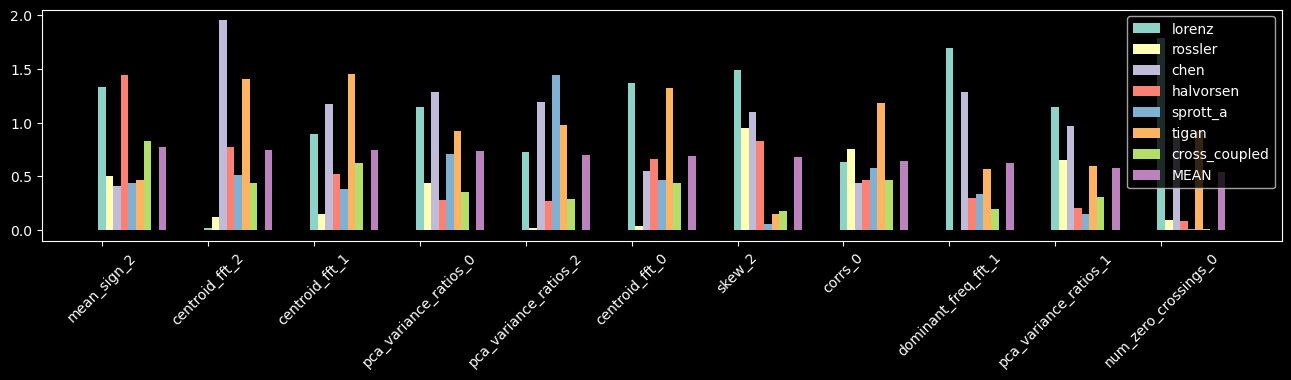

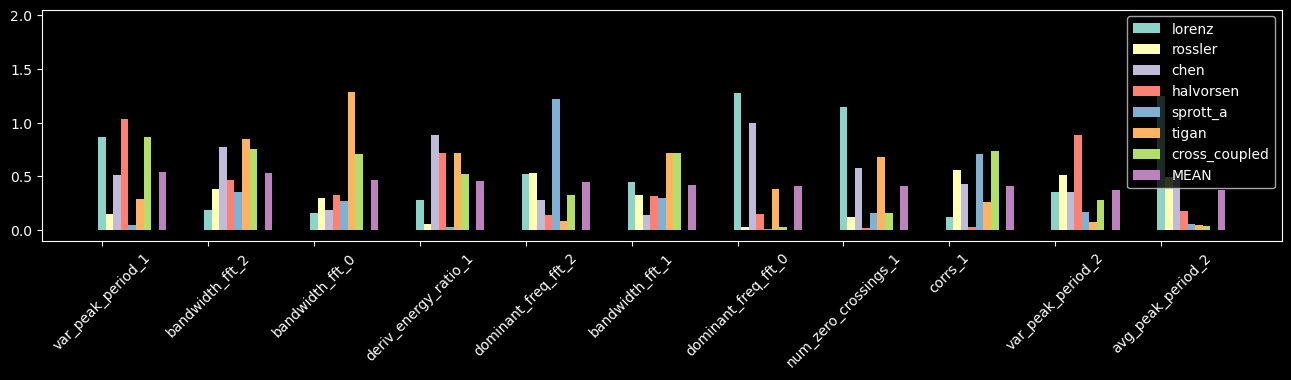

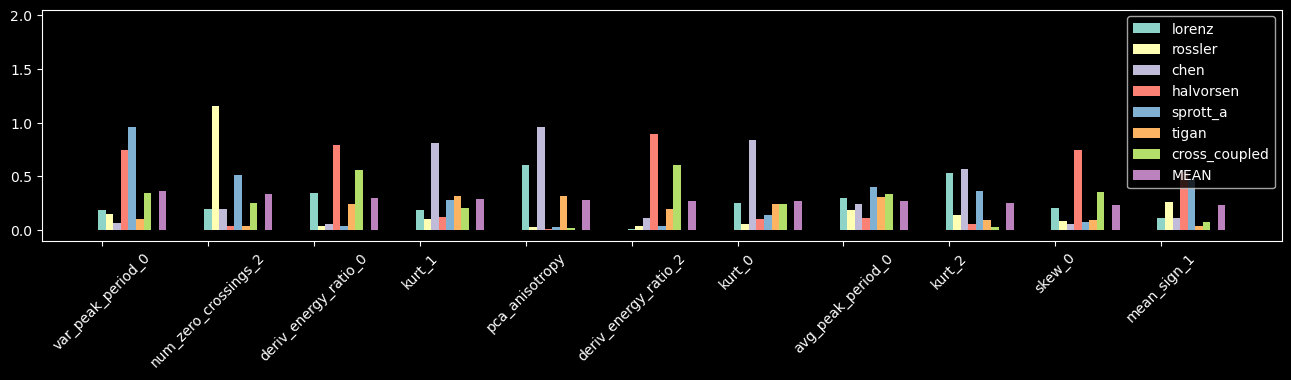

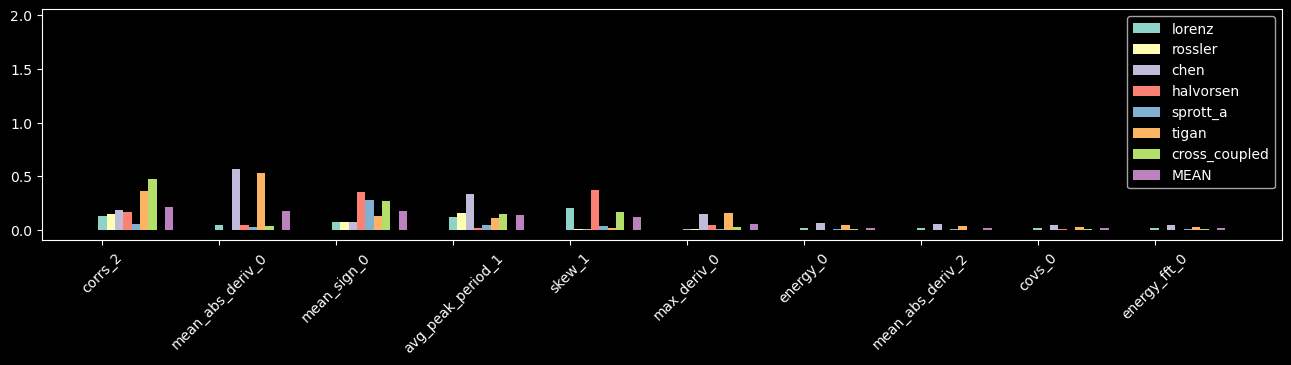

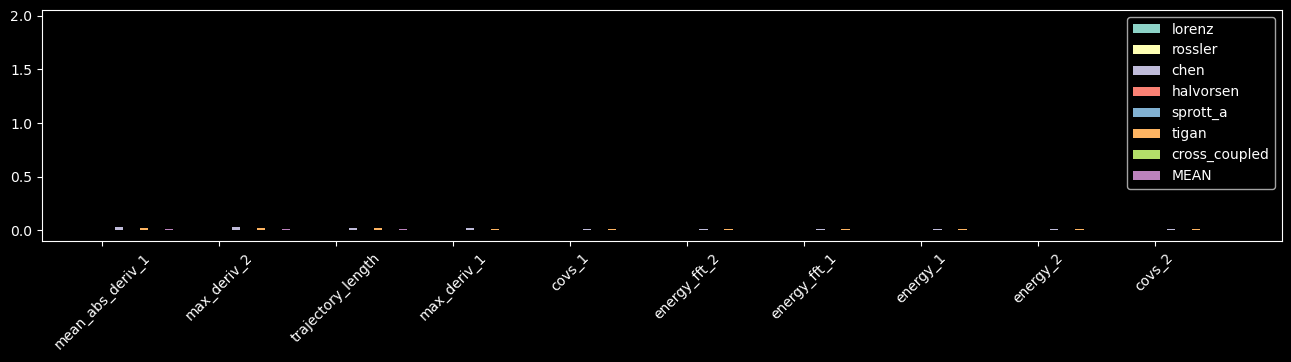

In [55]:
dims = df.target.nunique()

splits = np.array_split(abs(model.coef_)[:,importance_order[::-1]],5,axis=1)

start = 0
for ind, split in enumerate(splits):
    end = start + split.shape[1]
    plt.figure(figsize=(16,3))
    for i, (coefs, system) in enumerate(zip(split,df.system_name.unique())):    
        plt.bar(np.arange(len(coefs)) + i/(2*dims),abs(coefs),width=1/(2*dims),align='center',label=system)

    plt.bar(np.arange(len(coefs)) + (dims+1)/(2*dims), importance_mean[importance_order[::-1]][start:end], width=1/(2*dims), align='center',label='MEAN')
    
    plt.ylim([-0.1,np.max(abs(model.coef_))+0.1])
    feature_indices = np.arange(start,end)
    
    ticks = np.arange(len(coefs))
    labels = feature_cols[importance_order[::-1]][feature_indices]

    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.legend()
    plt.show()

    start = end